In [129]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import os
import re

os.environ["JAVA_HOME"] = "/usr/local/Cellar/openjdk@17/17.0.15/libexec/openjdk.jdk/Contents/Home"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [130]:
# Build spark session
spark = SparkSession \
    .builder \
    .appName("PaynetAssessment") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

# Confirm session is running
print("Spark version:", spark.version)

# Load the data from local file system
df_raw = spark.read.json("/Users/zhaothong/Documents/Career/2025/Paynet/cc_sample_transaction.json")
df_raw.show()

# Inspect the schema
df_raw.printSchema()

Spark version: 4.0.0


+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|             cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|  4.97|     misc_net|CITIUS33CHI|   2703186189652095|       0|1325376018798532|         1325376018666|         36.011293|        -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:18|0b242abb623afc

## JSON Flattening

The dataset contains nested JSON data inside the `personal_detail` column. To efficiently analyze and process this data, we flatten the nested JSON structure into a tabular format.

**Approach:**

- Define explicit schemas (`StructType`) for the nested JSON objects (`address` and `personal_detail`).
- Use the `from_json` function to parse the JSON string into a structured `StructType` column.
- Select and alias the nested fields as top-level columns in the DataFrame to create a flattened structure.
- This flattening enables easier access to nested attributes and simplifies downstream data processing, transformations, and analytics.


In [131]:
# Schema for address JSON STRING (as string fields)
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

# Schema for personal_detail outer JSON
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),  # Note: still string here!
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

# Step 1: parse personal_detail JSON string into struct
df_parsed = df_raw.withColumn("personal_detail_parsed", from_json(col("personal_detail"), personal_detail_schema))

# Step 2: parse the nested 'address' JSON string inside the struct
df_parsed = df_parsed.withColumn(
    "address_parsed",
    from_json(col("personal_detail_parsed.address"), address_schema)
)

# Step 3: flatten columns
df_flattened = df_parsed.select(
    "Unnamed: 0",
    "trans_date_trans_time",
    "cc_num",
    "merchant",
    "category",
    "amt",
    col("personal_detail_parsed.person_name").alias("full_name"),
    col("personal_detail_parsed.gender").alias("gender"),
    col("address_parsed.street").alias("address_street"),
    col("address_parsed.city").alias("city"),
    col("address_parsed.state").alias("state"),
    col("address_parsed.zip").alias("zip"),
    col("personal_detail_parsed.lat").alias("lat"),
    col("personal_detail_parsed.long").alias("long"),
    col("personal_detail_parsed.city_pop").alias("city_pop"),
    col("personal_detail_parsed.job").alias("job"),
    col("personal_detail_parsed.dob").alias("dob"),
    "trans_num",
    "merch_lat",
    "merch_long",
    "is_fraud",
    "merch_zipcode",
    "merch_last_update_time",
    "merch_eff_time",
    "cc_bic"
)

df_flattened.show(5, truncate=False)
df_flattened.printSchema()

+----------+---------------------+----------------+----------------------------------+-------------+------+--------------------+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+------------------+-----------+--------+-------------+----------------------+----------------+-----------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |full_name           |gender|address_street              |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |merch_lat         |merch_long |is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time  |cc_bic     |
+----------+---------------------+----------------+----------------------------------+-------------+------+--------------------+------+----------------------------+--------------+-----+-----+---

## Timestamp Conversion

The dataset contains timestamp columns in different formats and time zones that need standardization.

**Approach:**

- Convert `trans_date_trans_time` from string to timestamp and adjust from UTC to Asia/Kuala_Lumpur timezone.
- Convert `merch_last_update_time` from milliseconds (Unix epoch) to timestamp and adjust timezone.
- Convert `merch_eff_time` from microseconds to timestamp and adjust timezone.

This ensures all timestamps are in a consistent format and timezone for accurate analysis.


In [132]:
# Column: trans_date_trans_time
df_flattened = df_flattened.withColumn(
    "trans_date_trans_time",
    from_utc_timestamp(to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss"), "Asia/Kuala_Lumpur")
)

# Column: merch_last_update_time
df_flattened = df_flattened.withColumn(
    "merch_last_update_time",
    from_utc_timestamp(from_unixtime((col("merch_last_update_time") / 1000).cast("long")), "Asia/Kuala_Lumpur")
)

# Column: merch_eff_time
df_flattened = df_flattened.withColumn(
    "merch_eff_time",
    from_utc_timestamp((col("merch_eff_time") / 1_000_000).cast("timestamp"), "Asia/Kuala_Lumpur")
)

# Check the dataframe after conversion
df_flattened.show(truncate=False)
df_flattened.printSchema()

+----------+---------------------+-------------------+----------------------------------------+-------------+------+-------------------------+------+------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+----------------------+--------------------------+-----------+
|Unnamed: 0|trans_date_trans_time|cc_num             |merchant                                |category     |amt   |full_name                |gender|address_street                |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time            |cc_bic     |
+----------+---------------------+-------------------+------------

## Data Quality Assurance

To prepare the data for analysis, we apply key cleaning and validation steps.

**Approach:**

- Count missing values to identify gaps.
- Remove duplicate records to ensure uniqueness.
- Check distinct values in categorical columns for consistency.
- Convert date strings to date type and flag invalid dates.
- Cast numeric columns to correct types (integer, double).
- Convert binary flags to boolean.

These steps ensure the data is clean, consistent, and ready for further processing.

In [133]:
# Count missing values in each column
df_flattened.select([col(c).isNull().alias(c) for c in df_flattened.columns]).groupBy().sum().show()

# Count duplicates
df_flattened.count(), df_flattened.dropDuplicates().count()

# Check distinct value for categorical columns
df_flattened.printSchema()
df_flattened.select("is_fraud").distinct().show()
df_flattened.select("gender").distinct().show()
df_flattened.select("category").distinct().show()

# Clean 'cc_bic' column
df_flattened = df_flattened.withColumn(
    "cc_bic",
    when(
        (col("cc_bic").isNull()) | 
        (col("cc_bic") == "") | 
        (col("cc_bic").isin("NA", "na", "Na", "nA", "Null")),
        None
    ).otherwise(col("cc_bic"))
)

# Convert 'dob' to date type and drop the original 'dob' column
df_flattened = df_flattened.withColumn("dob", to_date("dob", "yyyy-MM-dd"))

# Convert 'amt' to double type
df_flattened = df_flattened.withColumn("amt", col("amt").cast(DoubleType()))

# Convert 'is_fraud' to boolean type
df_flattened = df_flattened.withColumn("is_fraud", col("is_fraud").cast("boolean"))

# Convert 'city_pop' to integer type
df_flattened = df_flattened.withColumn("city_pop", col("city_pop").cast("integer"))

# Convert 'lat' and 'long' to double type
df_flattened = df_flattened.withColumn("lat", col("lat").cast(DoubleType()))
df_flattened = df_flattened.withColumn("long", col("long").cast(DoubleType()))

# Convert 'merch_lat' and 'merch_long' to double type
df_flattened = df_flattened.withColumn("merch_lat", col("merch_lat").cast(DoubleType()))
df_flattened = df_flattened.withColumn("merch_long", col("merch_long").cast(DoubleType()))


++
||
++
||
++



root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- address_street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_eff_time: timestamp (nullable = true)
 |-- cc_bic: st

+--------+
|is_fraud|
+--------+
|       1|
|       0|
+--------+



+------+
|gender|
+------+
|     F|
|     M|
+------+



+--------------+
|      category|
+--------------+
|   grocery_pos|
|        travel|
| entertainment|
| gas_transport|
|   grocery_net|
| personal_care|
|   food_dining|
|health_fitness|
|  shopping_pos|
|          home|
|      misc_pos|
|  shopping_net|
|     kids_pets|
|      misc_net|
+--------------+



## Name Derivation
Extract first and last name columns from `full_name`

**Approach:**
- Clean full_name by removing unwanted characters and normalizing delimiters.
- Use a UDF to split names by comma or camel-case, handling messy formats.
- Extracts reliable first_name and last_name fields from dirty data.

In [134]:
# Step 1: Remove non-alphabetic characters except comma and space
df_flattened = df_flattened.withColumn(
    "clean_full_name",
    regexp_replace(col("full_name"), r"[^A-Za-z,\s]", "")
)

# Step 2: Replace multiple spaces, commas with a single comma
df_flattened = df_flattened.withColumn(
    "clean_full_name",
    regexp_replace(col("clean_full_name"), r"[,\s]+", ",")
)

# Step 3: UDF to split name
def clean_and_split(name):
    if not name:
        return ["", ""]

    parts = name.split(",")
    parts = [p.strip() for p in parts if p.strip() != ""]

    if len(parts) == 2:
        return [parts[0], parts[1]]
    elif len(parts) == 1:
        # Attempt camel-case split
        match = re.match(r"^([A-Z][a-z]+)([A-Z][a-z]+)$", parts[0])
        if match:
            return [match.group(1), match.group(2)]
        else:
            return [parts[0], None]
    else:
        return [parts[0], parts[1]] if len(parts) > 1 else ["", ""]

split_name_udf = udf(clean_and_split, ArrayType(StringType()))

# Step 4: Apply UDF
df_flattened = df_flattened.withColumn("name_parts", split_name_udf(col("clean_full_name")))
df_flattened = df_flattened.withColumn("first_name", col("name_parts").getItem(0))
df_flattened = df_flattened.withColumn("last_name", col("name_parts").getItem(1))

# Clean up
df_flattened = df_flattened.drop("clean_full_name", "name_parts")

# Check the final dataframe
df_flattened.show(n=100,truncate=False)


+----------+---------------------+-------------------+-------------------------------------------+-------------+------+--------------------------+------+-------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+----------------------+--------------------------+-----------+-----------+----------+
|Unnamed: 0|trans_date_trans_time|cc_num             |merchant                                   |category     |amt   |full_name                 |gender|address_street                 |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time            |cc_bic     |first_name |last_name |
+---------

## Handling PII Data

Sensitive personally identifiable information (PII) columns such as credit card numbers, names, and dates of birth are protected by applying **SHA-256 hashing**.

**Approach:**

- Identify the PII columns that must be secured.
- Use SHA-256 hashing to transform each PII value into a fixed-length irreversible hash string.
- Numeric columns (`lat`, `long`) are first cast to strings to ensure proper hashing.
- This method provides strong data privacy by masking original values irreversibly while still enabling operations like joins on hashed columns.
- Hashing preserves the schema and structure of the DataFrame, making it easy to integrate with downstream processing pipelines.

This approach helps maintain compliance with data privacy regulations and protects sensitive data from unauthorized access.


In [135]:
# Identify PII columns to be hashed
pii_columns = ["cc_num", "full_name", "first_name", "last_name", "dob", "address_street", "zip", "lat", "long", "gender"]

# Hashing PII columns
for column_name in pii_columns:
    if column_name in ["lat", "long", "dob"]:
        df_flattened = df_flattened.withColumn(column_name, sha2(col(column_name).cast("string"), 256))
    else:
        df_flattened = df_flattened.withColumn(column_name, sha2(col(column_name), 256))

# Show sample data after hashing PII columns
df_flattened.show(n=5, truncate=False)

+----------+---------------------+----------------------------------------------------------------+----------------------------------+-------------+------+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+--------------+-----+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+--------+---------------------------------+----------------------------------------------------------------+--------------------------------+------------------+-----------+--------+-------------+----------------------+--------------------------+-----------+----------------------------------------------------------------+----------------------------------------------------------------+
|Unnamed: 0|trans_date_trans_time|cc_num      

## Data Visualization

In [136]:
df_final = df_flattened

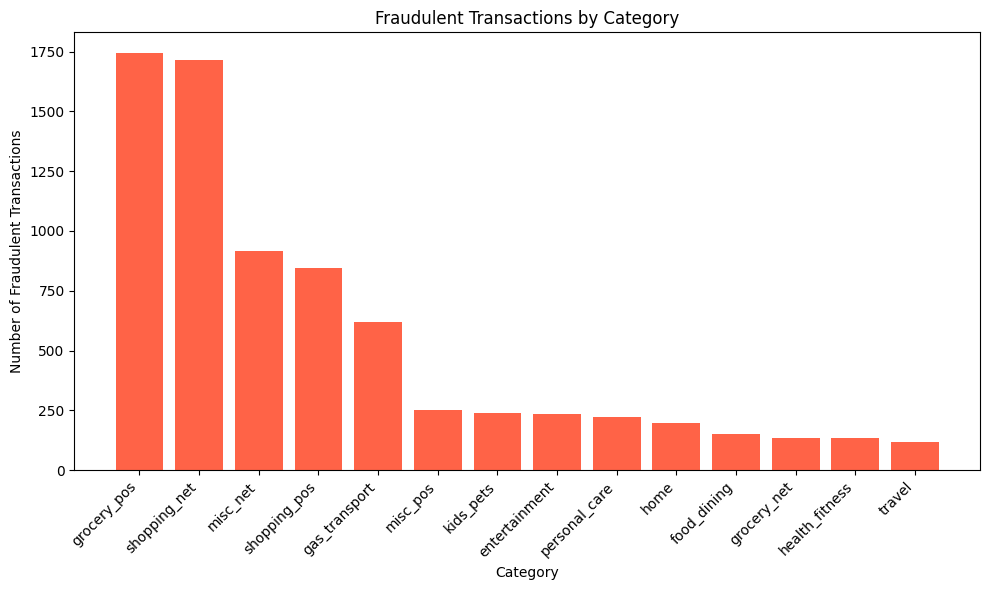

In [137]:
import matplotlib.pyplot as plt

# Aggregate fraud count by category
fraud_by_category = (
    df_final.filter("is_fraud = true")
    .groupBy("category")
    .count()
    .orderBy("count", ascending=False)
    .toPandas()
)

plt.figure(figsize=(10,6))
plt.bar(fraud_by_category['category'], fraud_by_category['count'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title("Fraudulent Transactions by Category")
plt.xlabel("Category")
plt.ylabel("Number of Fraudulent Transactions")
plt.tight_layout()
plt.show()


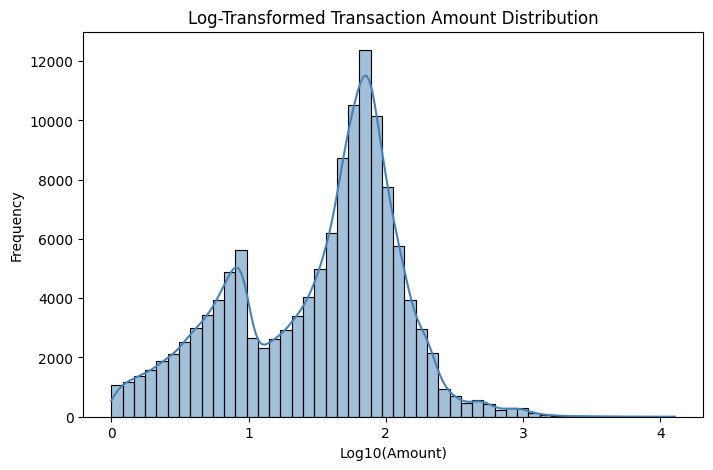

In [138]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data for plotting (drop zero or negative amounts before log)
amt_sample = (
    df_final.select("amt")
    .dropna()
    .filter("amt > 0")  # remove zero or negative amounts
    .sample(fraction=0.1)
    .toPandas()
)

# Apply log transformation
amt_sample['log_amt'] = np.log10(amt_sample['amt'])

plt.figure(figsize=(8,5))
sns.histplot(amt_sample['log_amt'], bins=50, kde=True, color='steelblue')
plt.title("Log-Transformed Transaction Amount Distribution")
plt.xlabel("Log10(Amount)")
plt.ylabel("Frequency")
plt.show()


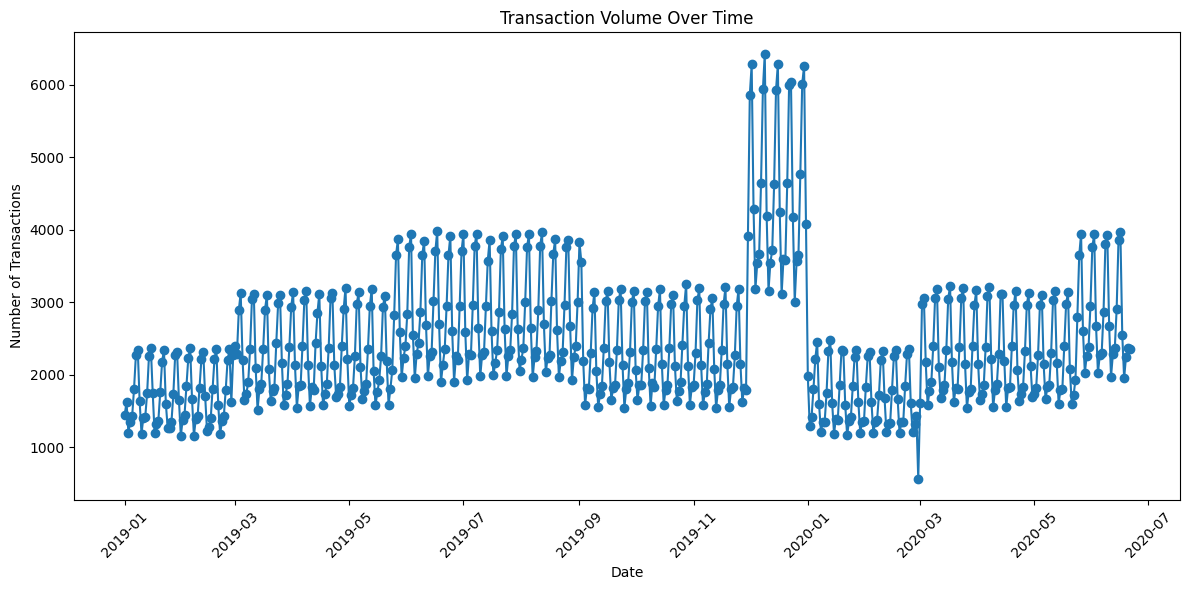

In [139]:
import pandas as pd

# Aggregate transactions by day
trans_by_day = (
    df_final.withColumn("trans_date", col("trans_date_trans_time").cast("date"))
    .groupBy("trans_date")
    .count()
    .orderBy("trans_date")
    .toPandas()
)

plt.figure(figsize=(12,6))
plt.plot(trans_by_day['trans_date'], trans_by_day['count'], marker='o', linestyle='-')
plt.title("Transaction Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
